## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [2]:
import pandas as pd
import pickle
df=pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens=df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


First, I can see some punctuation in the tokens, so I would probably remove strings that don't contain alphanumeric characters. It also might be worthwhile to remove words like 'the' and 'I' that will not contain any useful information about the content of the email. I could then use one-hot encoding to transform the data into a series of vectors that indicate the presence or abscence of each token, and then run any of a variety of regression algorithms on this data.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

<Axes: >

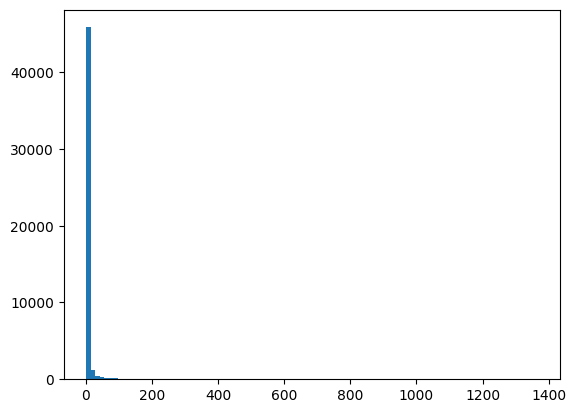

In [3]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
import matplotlib.pyplot as plt
token_count = Counter(all_tokens)
token_freq = token_count.most_common()
gdf=pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

In [4]:
gdf['count'].describe()

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

The mean is 5.69, but the standard deviation is 27, which suggests the data is not very normal. We see from the graph that it is very right skewed, meaning most tokens are on the left of the graph with very few occurrences. There are a few outliers of tokens that occur hundreds of times. Tokens that appear too few times might not be common enough to predict a scam, whereas tokens that appear too many times might just be common in almost every email and may also not be helpful in predicting scams.

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
df=pd.read_parquet('Phishing_clean.parquet')
y=df['Email Type']
X=df.drop(columns=['Email Type'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lm=LinearRegression()
lm.fit(X_train,y_train)
print(lm.score(X_train,y_train))
print(lm.score(X_test,y_test))

0.7670143724934355
0.6658718438847919


The model performs better on the training set than the test set, so it seems to be overfitting somewhat. The r^2 indicates the model is doing an ok job at predicting (better than random), but is low enough that we can likely improve it.

In [12]:
rdf=pd.DataFrame({'word':lm.feature_names_in_,'coef':lm.coef_})
rdf.sort_values('coef',ascending=False).head(10)

,word,coef
740,localized,0.824350
2362,thermal,0.747006
851,crawler,0.696167
1406,"helvetica,",0.598560
906,aging,0.594956
1839,form.,0.576886
1552,a:active,0.574480
1245,{text-decoration:,0.497075
2532,xanaax,0.491981
2566,transcript,0.488978


There doesn't seem to be any pattern among the words the model deems to be most useful, so much of this might be noise. Since the total number of words is fairly large, and many of the words are likely not useful in predicting whether the email is a scam or not, it is not surprising this approach doesn't make a great model.

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

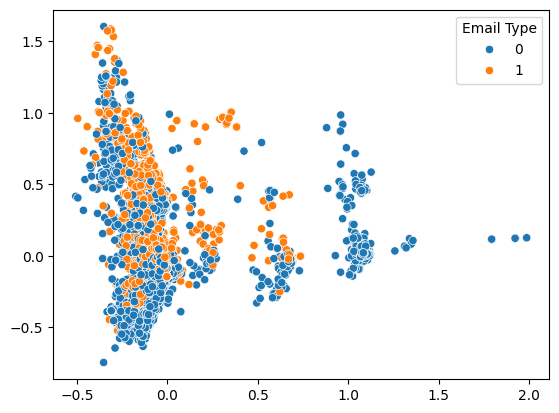

In [21]:
from sklearn.decomposition import PCA
import seaborn as sns
pca=PCA(n_components=2)
pca.fit(X_train)
train_pca=pca.transform(X_train)
test_pca=pca.transform(X_test)
sns.scatterplot(x=train_pca[:,0],y=train_pca[:,1],hue=y_train)

The scam emails tend to have a low first component (most <0). There seems to be less of a trend for the second component, but it generally seems to be higher than legitamate emails.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [22]:
pca=PCA(n_components=2610)
pca.fit(X_train)
train_pca=pca.transform(X_train)
test_pca=pca.transform(X_test)
lm2=LinearRegression()
lm2.fit(train_pca,y_train)
print(lm2.score(train_pca,y_train))
print(lm2.score(test_pca,y_test))

0.7662326827745849
0.6683390643101161


This performance seems pretty similar to the performance in question 3, on both the training and test sets. It is possible that due to the way I performed regression in #3, this was already accounted for by the linear regression method.

In [25]:
from sklearn.metrics import r2_score
df = pd.read_parquet('Phishing_clean.parquet')

y = df['Email Type']
X = df.drop('Email Type',axis=1)

## 1.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)

## 2.
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )

train:  0.6211283438578934
test:  0.5133615244927014


As a sanity check, I copied the exact code from the solution set. The r^2 for the training value is similar, but I can't seem to replicate the r^2 of close to 0 for the test set. Most of the decrease seems to come from setting fit_intercept to false.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

The disadvantage, as with many ml techniques, is that adding this layer of complexity can make the model more opaque. When we run regression just on the words, it is easy to see how influential a word is by checking the coefficient. Using PCA and the components makes it less intuitive what each weight means. The advantage is that by not running it on the original words and instead using the PCA components, we can remove potential colinearity from the original data (many of the words may be related to each other, making it difficult to determine each word's individual impact).